In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

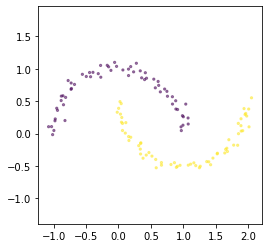

In [4]:
# Lightweight datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)
        x,c = moons
        x = x.astype(np.float32)
        c = c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

d = DatasetMoons()

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.axis('equal');

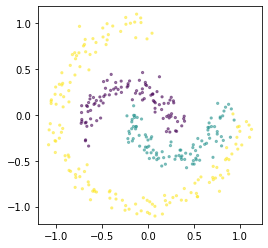

In [5]:
class DatasetMoons:
    """ two half-moons """
    def __init__(self, total_points = 1000, seed=None):
        if seed is not None:
            np.random.seed(seed) ## 148, 249
            
        xxc, yc = datasets.make_circles(n_samples=400, factor=.5,
                                        noise=.07)
        idx = yc==0
        xxc = xxc[idx]
        yc = yc[idx]
        idx = (xxc[:,0]+xxc[:,1]<1)
        xxc = xxc[idx]
        yc = yc[idx]

        xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
        xxm = xxm/2 - 0.2
        xx = np.concatenate((xxm, xxc), axis=0)
        y = np.concatenate((ym, yc+2), axis=0)
        
        self.x = xx
        self.c = y

    
    def sample(self, n):
        if n > len(self.x):
            n = len(self.x)
        x = self.x.astype(np.float32)
        c = self.c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

d = DatasetMoons()

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.axis('equal');

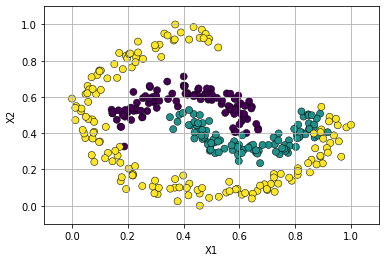

In [6]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=400, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.zeros(num_sets, input_dim)+0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter()

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [8]:
# ### for 10 num_sets
# prob = torch.softmax(torch.randn(2, 10), dim=1)
# prob.sum(dim=1, keepdim=True)

In [9]:
# ### for 5 classes
# weight = torch.softmax(torch.randn(10, 5), dim=1)
# weight.sum(dim=1, keepdim=True)

In [10]:
# (prob@weight).sum(dim=1)

In [11]:
# class ConnectedClassifier_SoftKMeans(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
#         self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
#         self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
#         self.cls_confidence = None
        
        
#     def forward(self, x):
#         dists = torch.norm(x.unsqueeze(-1)-self.centers.unsqueeze(0), dim=1)
#         x = torch.softmax(dists*self.inv_temp, dim=1)
#         self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
# #         c = self.cls_weight
#         return x@c ## since both are normalized, it is also normalized

In [12]:
# cent = torch.rand(2, 5)*2-1
# cent.shape

In [13]:
# dat = torch.randn(3, 2)
# dat.shape

In [14]:
# dists = torch.norm(dat.unsqueeze(-1)-cent.unsqueeze(0), dim=1)

In [15]:
# torch.softmax(dists, dim=1)

In [16]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*20-1)
        self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
#         print(dists)
#         for i in range(len(self.centers)):
#             print(torch.norm(x-self.centers[i:i+1], dim=1))
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [17]:
a = torch.tensor([[0.9041,  0.0196], [-0.3108, -2.4423], [-0.4821,  1.059]])

In [18]:
b = torch.tensor([[-2.1763, -0.4713], [-0.6986,  1.3702], [-0.6986,  1.3702]])

In [19]:
torch.cdist(a, b, p=2)

tensor([[3.1193, 2.0959, 2.0959],
        [2.7138, 3.8322, 3.8322],
        [2.2830, 0.3791, 0.3791]])

In [20]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
        ]

model = SequentialFlow(flows)

In [21]:
model

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
    (1): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (2): ActNorm()
    (3): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (4): ActNorm()
  )
)

In [22]:
# classifier = ConnectedClassifier(2, 50, 3)
classifier = ConnectedClassifier_SoftKMeans(2, 10, 3)

In [23]:
# torch.norm(torch.randn(5, 2)-classifier.centers[0:1], dim=1)

In [24]:
# classifier(torch.randn(5, 2))

In [25]:
# dat = torch.cdist(torch.randn(4, 2), classifier.centers)
# dat

In [26]:
# torch.softmax(-dat, dim=1)

In [27]:
# torch.argmin(dat, dim=1)

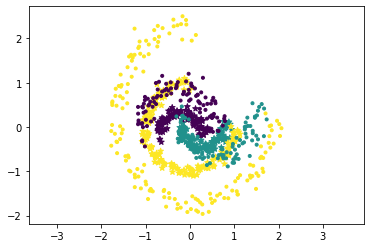

In [28]:
x,c = d.sample(128)
z, logDetJ = model(x, True)
z = z.data.detach()
%matplotlib inline
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)
plt.axis('equal');

In [29]:
# jpt text to stop execution

## Model Train

In [30]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()),
                       lr=0.001, weight_decay=1e-5) # todo tune WD
# optimizer = optim.SGD(model.parameters(), lr=0.1)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1018


In [31]:
# model.train()
# losses = []
# NUM = 512
# for k in tqdm(range(1000*2+1)):
#     optimizer.zero_grad()
    
#     x,c = d.sample(NUM)
#     z = model(x, False)
# #     print(z.shape)
#     y = classifier(z)
# #     print(y.shape)
# #     print(c.shape, c.dtype)
#     loss = criterion(y, c)
#     loss.backward()
#     optimizer.step()
    
# #     break
#     if k % 200 == 0:
#         losses.append(float(loss))
#         print("Loss:", k, losses[-1])
#         print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())


  0%|          | 0/4001 [00:00<?, ?it/s]

Loss: 0 1.098549246788025
logDetJ: tensor(1.2405) tensor(1.2743)


  2%|▏         | 100/4001 [00:04<01:11, 54.23it/s]

Loss: 100 1.0826534032821655
logDetJ: tensor(2.6658) tensor(2.8753)


  5%|▍         | 198/4001 [00:08<01:06, 57.05it/s]

Loss: 200 1.0530540943145752
logDetJ: tensor(3.0710) tensor(3.5432)


  7%|▋         | 295/4001 [00:12<01:12, 51.26it/s]

Loss: 300 0.9874666929244995
logDetJ: tensor(3.1864) tensor(3.8336)


 10%|▉         | 395/4001 [00:16<01:06, 54.10it/s]

Loss: 400 0.9391345977783203
logDetJ: tensor(3.1592) tensor(3.7747)


 12%|█▏        | 497/4001 [00:20<00:59, 58.72it/s]

Loss: 500 0.8970236778259277
logDetJ: tensor(3.2647) tensor(4.1006)


 12%|█▏        | 500/4001 [00:22<02:39, 21.89it/s]


TclError: invalid command name "."

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise D

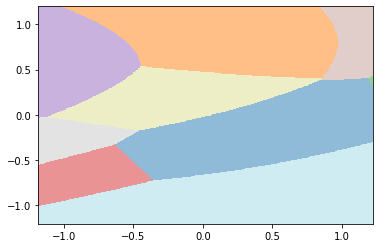

In [33]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x_ = torch.Tensor(xy)


for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    x,c = d.sample(NUM)
    z = model(x, False)
#     print(z.shape)
    y = classifier(z)
#     print(y.shape)
#     print(c.shape, c.dtype)
    loss = criterion(y, c)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        
        losses.append(float(loss))
#         print()        
        print("Loss:", epoch, losses[-1])

        ax.clear()
        ax.scatter(x[:,0], x[:,1], marker='o', c=torch.argmax(y, dim=1).reshape(-1))    
        
        with torch.no_grad():
            z, logDetJ = model(x_, True)
            y = torch.argmax(classifier(z, hard=True), dim=1)
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())
            
        cls = torch.argmax(classifier.cls_confidence, dim=1)
#         for i, u in enumerate(torch.unique(cls)):
#             cls[cls==u] = i
            
        plt.imshow(cls.reshape(xv.shape), interpolation='nearest',
           extent=(xv.min(), xv.max(), yv.min(), yv.max()),
           cmap='tab20',#matplotlib.colors.ListedColormap(colors[1:-1]),
           alpha=0.5,
           aspect='auto', origin='lower')

#         plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')
            
            
#         ax.scatter(x_[:,0], x_[:,1], marker='.', c=cls, cmap='tab10')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


In [115]:
asdfsdf

NameError: name 'asdfsdf' is not defined

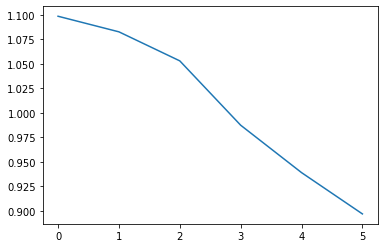

In [36]:
%matplotlib inline
plt.plot(losses)

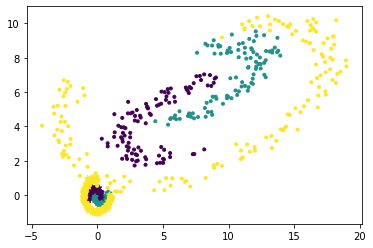

In [37]:
with torch.no_grad():
    x,c = d.sample(200)
    z = model(x, False)
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)   

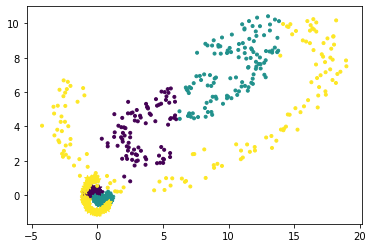

In [38]:
y = torch.argmax(classifier(z), dim=1)
plt.scatter(x[:,0], x[:,1], marker='*', c=y.reshape(-1))
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

In [40]:
torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

(tensor([0, 1, 3, 4, 7, 8, 9]), tensor([120,  18,  16,  33,  16,  89,  58]))

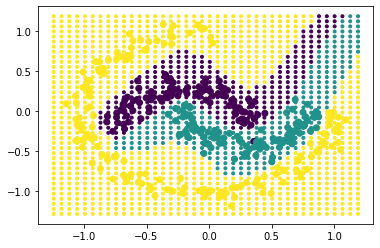

In [350]:
model.eval()

ng = 40
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x_ = torch.Tensor(xy)

with torch.no_grad():
#     x,c = d.sample(200)
    z = model(x_, False)
    y = torch.argmax(classifier(z), dim=1)
    
plt.scatter(x_[:,0], x_[:,1], marker='.', c=y.reshape(-1))
x,c = d.sample(200)
plt.scatter(x[:,0], x[:,1], marker='o', c=c.reshape(-1))

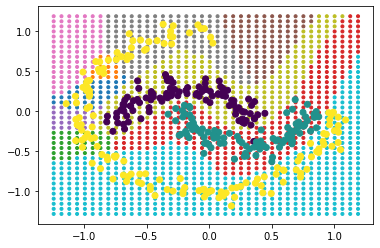

In [351]:
cls = torch.argmax(classifier.cls_confidence, dim=1)
for i, u in enumerate(torch.unique(cls)):
    cls[cls==u] = i

plt.scatter(x_[:,0], x_[:,1], marker='.', c=cls, cmap='tab10')
plt.scatter(x[:,0], x[:,1], marker='o', c=c.reshape(-1))

In [352]:
classifier.centers.data.t()

tensor([[ 7.3260,  8.5141,  0.3140,  5.4552,  2.5101, 15.4861,  7.9226, 10.9729,
          6.4335, -1.4836],
        [12.1026, 12.4782,  6.6561,  0.0858,  8.9765,  8.8156, 13.8825, 11.5524,
          5.5005, -2.0948]])

In [353]:
classifier.inv_temp

Parameter containing:
tensor([4.0952], requires_grad=True)

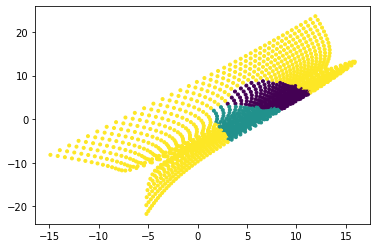

In [354]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

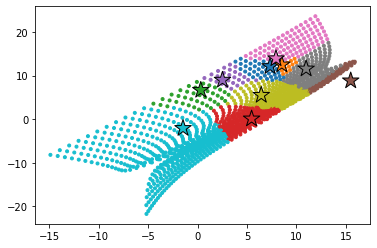

In [355]:
plt.scatter(z[:,0], z[:,1], marker='.', c=cls, cmap='tab10')   
centers = torch.zeros(classifier.num_sets, z.shape[1])
for i, c in enumerate(classifier.centers.data.t()):
    centers[:, i] = c
plt.scatter(*centers.t(), marker='*', s=300, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

In [356]:
torch.unique(cls)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [357]:
torch.unique(cls, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 39,  15,  41, 290,  27, 100,  93, 164, 279, 552]))

In [344]:
list(range(classifier.num_sets))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

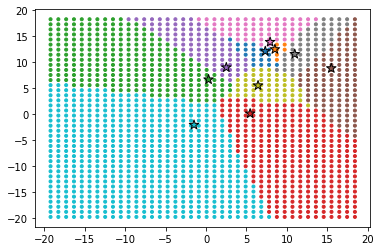

In [345]:
x__ = x_*(centers.max())
classifier(x__)
cls_ = torch.argmax(classifier.cls_confidence, dim=1)
# for i, u in enumerate(torch.unique(cls_)):
#     cls_[cls_==u] = i
plt.scatter(x__[:,0], x__[:,1], marker='.', c=cls_, cmap='tab10') 
plt.scatter(*centers.t(), marker='*', s=100, edgecolors='k', c=list(range(classifier.num_sets)), cmap='tab10')

torch.Size([400, 2])


Text(0.5, 1.0, 'x -> z')

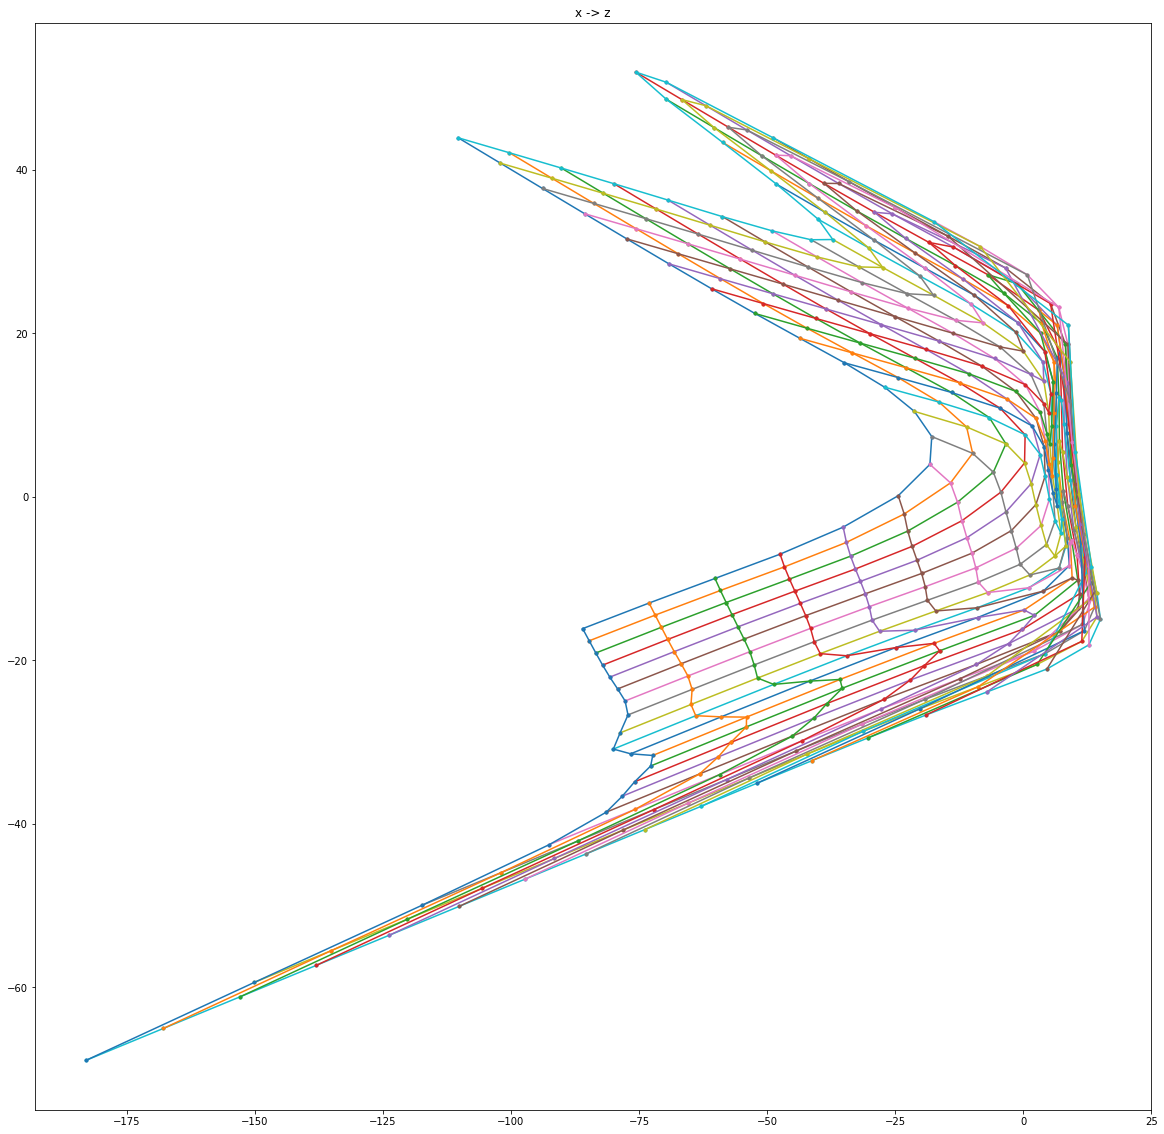

In [299]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z = model(x)
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    
plt.title('x -> z')